# Finite Differences
Solving golden model 1 using the following approximation

$\frac{u^{n+1/2}_{ij} - u^{n}_{ij}}{\tau}$ = $\Lambda_{i}u^{n+1/2}_{ij} + \Lambda_{j}u^{n}_{ij} - f_{ij}$

$\frac{u^{n+1}_{ij} - u^{n+1/2}_{ij}}{\tau}$ = $\Lambda_{j}(u^{n+1}_{ij} - u^{n}_{ij})$

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.sparse.linalg as spalg
from scipy.sparse import csc_matrix
import time

## 1. Plot the actual solution

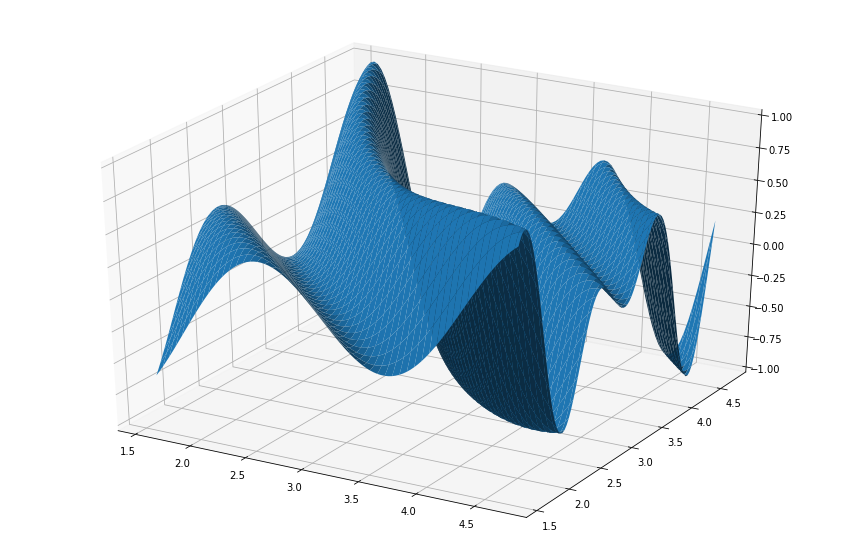

In [2]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

x_start = np.pi / 2.0
x_end = 1.5 * np.pi
N = 100
x_delta = (x_end - x_start) / (N-1)

y_start = np.pi / 2.0
y_end = 1.5 * np.pi
N = 100
y_delta = (y_end - y_start) / (N-1)

X = np.arange(x_start, x_end+0.1*x_delta, x_delta)
Y = np.arange(y_start, y_end+0.1*y_delta, y_delta)
X, Y = np.meshgrid(X, Y)
Z = np.cos(X + Y) * np.sin(X*Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-1, 1)

plt.show()

## 2. Time t=0, we have
Here we choose xy convention for how grid looks in numpy matrices. xy-convention means that

```python
x-grid = [[x0, x1, x2, x3], [x0, x1, x2, x3], ...]
y-grid = [[y0, y0, y0, y0], [y1, y1, y1, y1], [y2, y2, y2, y2]
```

In [66]:
class Minimizer:
    def __init__(self, grid, eps, gold_func, f_func, initValue, ):
        self.eps = eps
        self.u_gold_func = gold_func
        self.f_func = f_func
        
        self.condSatisfied = False
        self.iterations = 0
        self.solver = spalg.spsolve
        
        # x conditions
        self.Nx = grid["Nx"]
        self.x_start = np.pi * 0.5
        self.x_end = np.pi * 1.5
        self.x_delta = (self.x_end - self.x_start) / (Nx - 1)

        # y conditions
        self.Ny = grid["Ny"]
        self.y_start = np.pi * 0.5
        self.y_end = np.pi * 1.5
        self.y_delta = (self.y_end - self.y_start) / (Ny - 1)
        self.tau = grid["tau"]
        
        X = np.arange(self.x_start, self.x_end+0.1*self.x_delta, self.x_delta)
        Y = np.arange(self.y_start, self.y_end+0.1*self.y_delta, self.y_delta)
        self.X, self.Y = np.meshgrid(X, Y)
        self.u_gold = self.u_gold_func(self.X, self.Y)
        
        # initial values for the grid
        self.u_values = np.zeros((self.Ny, self.Nx))
        self.u_values.fill(initValue)
        
        # values for the f-function
        self.f_values = self._compute_f_values(self.Nx, self.Ny, self.x_delta, self.y_delta, self.x_start, self.y_start)
        
        # A matrix
        self.A_matrix = csc_matrix(self._compute_matrix_A_step0(self.Nx, self.Ny, self.x_delta, self.y_delta, self.tau))
        
        self.max_eps_list = []
        self.deviations = []
    
    def step(self, verbose=False):
        start = time.time()
        # build b values for step 0 (aka n+1/2)
        b_step0 = self._compute_vector_b(self.u_values, self.u_gold_func, self.f_values, self.tau, self.x_start, self.x_delta, self.Nx, self.y_start, self.y_delta, self.Ny, verbose)
        b_step0 = b_step0.flatten() # linearize
        # solve
        self.u_values_new = self.solver(self.A_matrix, b_step0).reshape((self.Ny, self.Nx))
        end = time.time()
    
        # compute the error
        self.max_eps = self._compute_max_eps(self.u_values_new, self.u_values, self.tau)
        self.max_eps_list.append(self.max_eps)
        if self.max_eps < self.eps: 
            self.condSatisfied = True
        if verbose:
            print(self.u_values)
            print(self.u_values_new)
            print(self.u_values_new - self.u_values)
        self.u_values = self.u_values_new
        self.deviations.append(np.amax(np.abs(self.u_values - self.u_gold)))
        self.iterations += 1
        if verbose:
            print (self.iterations, self.max_eps, self.eps)
    
    def minimize(self, maxIterations=10, verbose=False):
        while not self.condSatisfied and self.iterations < maxIterations:
            self.step(verbose=verbose)
        print (self.iterations, self.max_eps, self._compute_max_eps(self.u_values, self.u_gold, self.tau), self.eps)

    
    def _compute_f_values(self, Nx, Ny, x_delta, y_delta, x_start, y_start):
        i = np.arange(0, Nx, 1)
        j = np.arange(0, Ny, 1)
        i, j = np.meshgrid(i, j, indexing='xy')
        x = i*x_delta + x_start
        y = j*y_delta + y_start
        return self.f_func(x, y)
    
    def _compute_vector_b(self, u_values, u_gold_func, f_values, tau, x_start, x_delta, Nx, y_start, y_delta, Ny, verbose):
        i = np.arange(0, Nx, 1)
        j = np.arange(0, Ny, 1)
        i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
        x_mesh = i_mesh * x_delta + x_start
        y_mesh = j_mesh * y_delta + y_start
    
        # b values
        b = np.zeros((Ny, Nx))
    
        # boundary
        b[i_mesh==0] = u_gold_func(x_mesh[i_mesh==0], y_mesh[i_mesh==0])
        b[i_mesh==Nx-1] = u_gold_func(x_mesh[i_mesh==Nx-1], y_mesh[i_mesh==Nx-1])
        b[j_mesh==0] = u_gold_func(x_mesh[j_mesh==0], y_mesh[j_mesh==0])
        b[j_mesh==Ny-1] = u_gold_func(x_mesh[j_mesh==Ny-1], y_mesh[j_mesh==Ny-1])
    
        # internal network
        x_delta_2 = x_delta * x_delta
        y_delta_2 = y_delta * y_delta
        L1L2u = 1 / (x_delta_2 * y_delta_2) * (
            (u_values[2:Ny, 2:Nx] - 2*u_values[2:Ny, 1:Nx-1] + u_values[2:Ny, 0:Nx-2])
            - 2*(u_values[1:Ny-1, 2:Nx] - 2*u_values[1:Ny-1, 1:Nx-1] + u_values[1:Ny-1, 0:Nx-2]) 
            + (u_values[0:Ny-2, 2:Nx] - 2*u_values[0:Ny-2, 1:Nx-1] + u_values[0:Ny-2, 0:Nx-2])
        )
        b[1:Ny-1, 1:Nx-1] = u_values[1:Ny-1, 1:Nx-1] - tau * f_values[1:Ny-1, 1:Nx-1] + tau * tau * L1L2u
        return b

    def _linearize(self, row, col, Ncols):
        return row*Ncols + col

    def _compute_matrix_A_step0(self, Nx, Ny, x_delta, y_delta, tau):
        i = np.arange(0, Nx, 1)
        j = np.arange(0, Ny, 1)
        i_mesh, j_mesh = np.meshgrid(i, j, indexing="xy")
        x_mesh = i_mesh * x_delta + x_start
        y_mesh = j_mesh * y_delta + y_start
    
        # non-zero values of the A matrix
        # for uij, we have 1 + 2*tau*/h^2
        # for ui+1j, we have -tau/h^2
        # for ui-1j, we have -tau/h^2
        x_delta_2 = x_delta * x_delta
        y_delta_2 = y_delta * y_delta
        a_matrix = np.zeros((Ny*Nx, Ny*Nx), dtype=float)
        for eq in range(Ny*Nx):
            j_eq = int(eq / Nx)
            i_eq = eq % Nx
            # if this is a nodeon the boundary
            if i_eq==0 or i_eq==Nx-1 or j_eq==0 or j_eq==Ny-1:
                a_matrix[eq, eq] = 1
            else:
                # these are all the indices we need
                eq_id = self._linearize(j_eq, i_eq-1, Nx)
                eq_iu = self._linearize(j_eq, i_eq+1, Nx)
                eq_jd = self._linearize(j_eq-1, i_eq, Nx)
                eq_ju = self._linearize(j_eq+1, i_eq, Nx)
                eq_iu_ju = self._linearize(j_eq+1, i_eq+1, Nx)
                eq_iu_jd = self._linearize(j_eq-1, i_eq+1, Nx)
                eq_id_ju = self._linearize(j_eq+1, i_eq-1, Nx)
                eq_id_jd = self._linearize(j_eq-1, i_eq-1, Nx)
            
                # write down the values
                a_matrix[eq, eq] = 1 + 2*tau/x_delta_2 + 2*tau/y_delta_2 + tau*tau/(x_delta_2*y_delta_2)*(+4)
                a_matrix[eq, eq_id] = -tau/x_delta_2 + tau*tau/(x_delta_2*y_delta_2) * (-2)
                a_matrix[eq, eq_iu] = -tau/x_delta_2 + tau*tau/(x_delta_2*y_delta_2) * (-2)
                a_matrix[eq, eq_jd] = -tau/x_delta_2 + tau*tau/(x_delta_2*y_delta_2) * (-2)
                a_matrix[eq, eq_ju] = -tau/x_delta_2 + tau*tau/(x_delta_2*y_delta_2) * (-2)
                a_matrix[eq, eq_iu_ju] = tau*tau/(x_delta_2*y_delta_2)*(1)
                a_matrix[eq, eq_iu_jd] = tau*tau/(x_delta_2*y_delta_2)*(1)
                a_matrix[eq, eq_id_ju] = tau*tau/(x_delta_2*y_delta_2)*(1)
                a_matrix[eq, eq_id_jd] = tau*tau/(x_delta_2*y_delta_2)*(1)

        return a_matrix
                
    def _compute_max_eps(self, u_new, u, tau):
        return np.amax(np.abs(u_new - u))/tau


In [67]:
u_gold_func = lambda x,y: np.cos(x + y) * np.sin(x*y)
f_func = lambda x,y: -np.cos(x+y)*np.sin(x*y)*(2 + x*x + y*y)- 2*np.sin(x+y)*np.cos(x*y)*(x+y)
C = u_gold_func(np.pi*0.5, np.pi*.05)

In [74]:
mini = Minimizer(grid={"Ny" : 100, "Nx": 100, "tau": 0.001}, eps=0.00001, gold_func=u_gold_func, 
                 f_func=f_func, initValue=C)

In [75]:
mini.minimize(maxIterations=100, verbose=False)

100 2.5674740750770697 296.96262980669064 1e-05


In [76]:
def show3d(X, Y, Z):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    
    surf = ax.plot_surface(X, Y, Z)
    ax.set_zlim(-1, 1)

    plt.show()
    
def showProjection(X, gold, model):
    plt.plot(X, gold, 'ro', X, model, 'bo')
    plt.show()
    
def showAll(X, Y, u_values, u_gold, projection):
    show3d(X, Y, u_gold)
    show3d(X, Y, u_values)
    show3d(X, Y, u_gold - u_values)
    showProjection(X[0], u_gold[projection], u_values[projection])
    showProjection(Y[:, 0], u_gold[projection], u_values[projection])

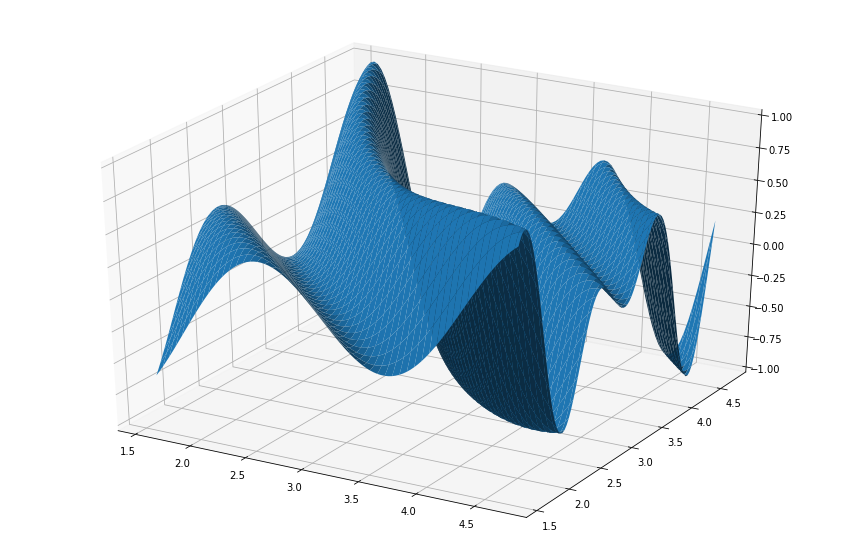

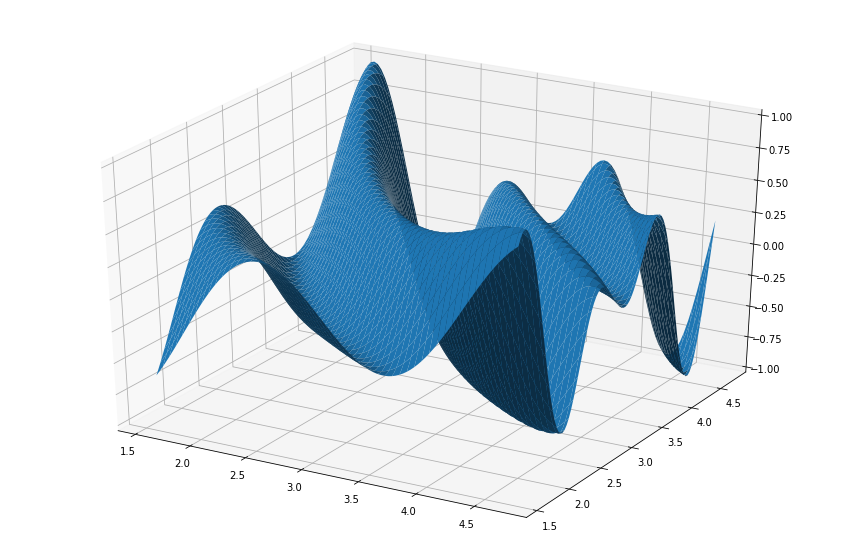

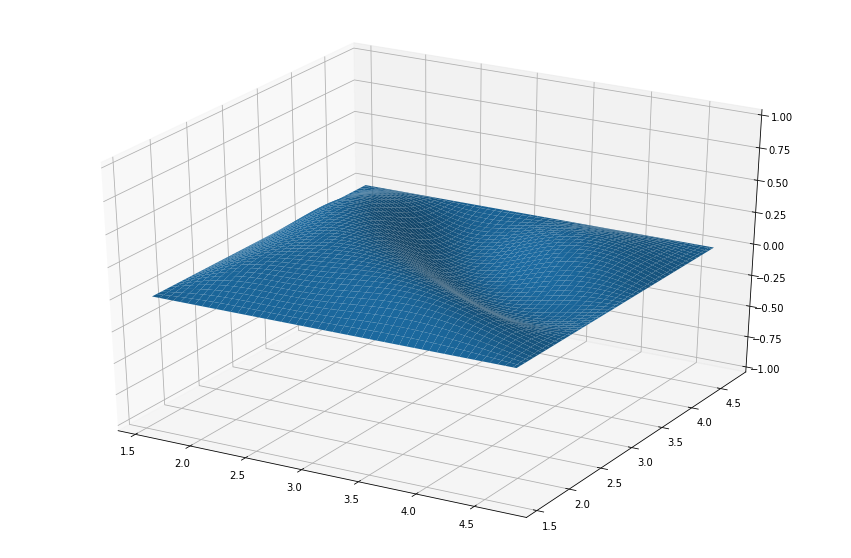

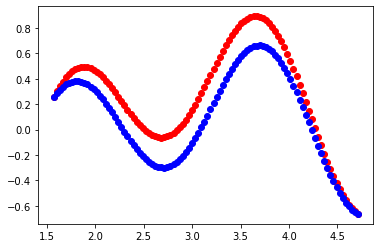

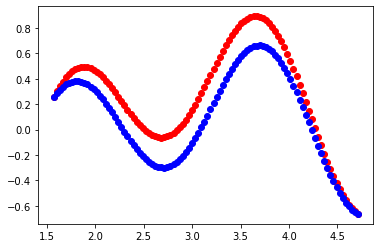

In [77]:
showAll(mini.X, mini.Y, mini.u_values, mini.u_gold, 20)

## Run various minimizations

In [105]:
taus = [0.0001, 0.0005, 0.001, 0.005, 0.01]
colors = ['bo', 'go', 'ro', 'co', 'ko']
minis = []
iterations = 100

In [106]:
for tau in taus:
    m = Minimizer(grid={"Ny" : 100, "Nx": 100, "tau": tau}, eps=0.00001, gold_func=u_gold_func, 
                 f_func=f_func, initValue=C)
    m.minimize(maxIterations=iterations, verbose=False)
    minis.append(m)

100 38.77540765065634 8116.964769029229 1e-05
100 6.9132972980177065 848.739873833771 1e-05
100 2.5674740750770697 296.96262980669064 1e-05
100 0.22105950461867307 14.203577133604005 1e-05
100 0.04776992121422463 2.230106010989424 1e-05


## Understand the impact of $\tau$ on convergence

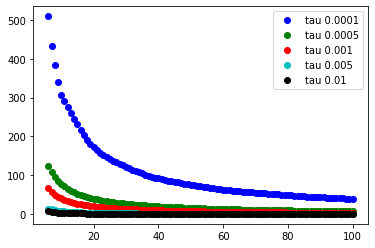

In [109]:
iters = np.arange(1, iterations+1, 1)
for i in range(len(minis)):
    plt.plot(iters[5:], minis[i].max_eps_list[5:], colors[i], label = "tau " + str(taus[i]))
plt.legend()
plt.show()

## Understand the impact of $\tau$ on precision of the solution

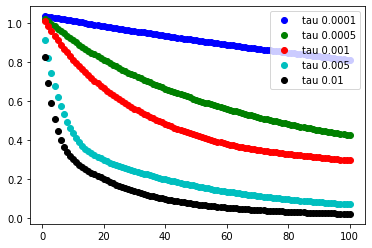

In [111]:
iters = np.arange(1, iterations+1, 1)
for i in range(len(minis)):
    plt.plot(iters, minis[i].deviations, colors[i], label = "tau " + str(taus[i]))
plt.legend()
plt.show()

## Run various minimizations

In [113]:
initValues = [-0.5, -0.25, 0, 0.25, 0.5]
colors = ['bo', 'go', 'ro', 'co', 'ko']
minis = []
iterations = 100

In [114]:
for initValue in initValues:
    m = Minimizer(grid={"Ny" : 100, "Nx": 100, "tau": 0.001}, eps=0.00001, gold_func=u_gold_func, 
                 f_func=f_func, initValue=initValue)
    m.minimize(maxIterations=iterations, verbose=False)
    minis.append(m)

100 4.010242800924712 746.4121790529246 1e-05
100 3.2202530080124303 502.9109726706332 1e-05
100 2.4513316427177134 259.88320564369343 1e-05
100 2.7749805849536235 421.3639196614679 1e-05
100 3.396195046693473 669.7664207706584 1e-05


## Understand the impact of $\tau$ on convergence

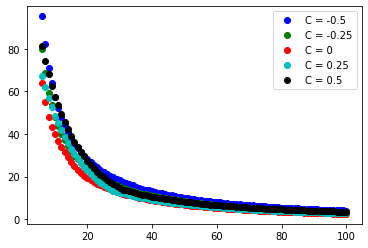

In [117]:
iters = np.arange(1, iterations+1, 1)
for i in range(len(minis)):
    plt.plot(iters[5:], minis[i].max_eps_list[5:], colors[i], label = "C = " + str(initValues[i]))
plt.legend()
plt.show()

## Understand the impact of $\tau$ on precision of the solution

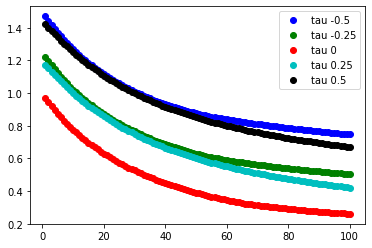

In [118]:
iters = np.arange(1, iterations+1, 1)
for i in range(len(minis)):
    plt.plot(iters, minis[i].deviations, colors[i], label = "tau " + str(initValues[i]))
plt.legend()
plt.show()